# Final Report - Group 35

## Introduction

The National Basketball Association (NBA) is a professional basketball league with 30 teams from the United States and Canada. Every year, teams play 82 games in the regular season followed by a best of 7 series in each round of the playoffs with the hopes of claiming the championship trophy.

During the game, only five players from each team are allowed on the court: Point Guard, Shooting Guard, Small Forward, Power Forward, and Center. Point guards run the offense as they are the team's best passers and dribblers, whereas Shooting Guards are usually the team's most proficient shooters. However, Point Guards and Shooting Guards (guards), are typically positioned outside the three point line on offense leading them to score the majority of three-pointers, followed by Small Forwards, Power Forwards, and Centers. Recently, point guards have caught up to shooting guards in scoring three-pointers, which raises the question of where to position a good shooter.

We will analyze the NBA player stats for the 2017-18 season, which contain information about a player's position, three-pointers made, games played, etc., for 490 unique NBA players, to try and determine whether there is a difference in the number of three-point shots made per game by all Point Guards and Shooting Guards that are in the NBA.

NBA players, coaches, and staff get paid based on their performance and winning the championship leads to hefty bonuses given for them all. Therefore, this question is critical as it could assist coaches in deciding where to play their finest three-point shooter. Furthermore, it provides vital information for organizations searching for new Point and Shooting Guards during free agency or in upcoming drafts. By constructing a team or positioning a guard based on their current three-point abilities, teams could gain a competitive advantage which could ultimately lead to them claiming the prestigious championship title.

As such, our population of interest is comprised of all current and future point guards and shooting guards in the NBA within the next 10 years. The data from this season is a random cluster sample, and is likely to be representative of the population.

## Methods

### Overview

1. **Reading, Wrangling & Cleaning:** Loading the dataset from the web, removing and filtering for relevant variables, and standardizing the variable of interest.

2. **Exploratory Data Analysis:** Computing summary statistics of the variable of interest across and visualizing the sample distribution.

3. **Hypothesis Test:** Conducting a theory-based hypothesis test based on the chosen variable of interest.

4. **Comparison with Confidence Interval:** Comparing hypothesis test results with a 95% bootstrap confidence interval.
    
5. **Results and Analysis:** Analyzing and summarizing the results.

### Loading Libraries

In [37]:
library(cowplot)
library(datateachr)
library(digest)
library(infer)
library(repr)
library(taxyvr)
library(tidyverse)
library(broom)
library(digest)
library(testthat)

### Reading, Cleaning & Wrangling 

We set the seed to 35 so all randomized processes will reproducible. Next we load our dataset from the web and save it to `nba_stats`.

In [38]:
# Setting the seed
set.seed(35)

# Reading in the raw data
# Original source: https://www.kaggle.com/datasets/mcamli/nba17-18
nba_stats <- read_csv("https://raw.githubusercontent.com/Ne1sonLi/STAT-201-Project-Group-35/main/players_stats.csv")


# Display the first 6 rows of the raw data
head(nba_stats)

Rows: 490 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (7): Name, Birth_Place, Birthdate, Collage, Experience, Pos, Team
dbl (27): Games Played, MIN, PTS, FGM, FGA, FG%, 3PM, 3PA, 3P%, FTM, FTA, FT...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Name,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,⋯,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
AJ Price,26,324,133,51,137,37.2,15,57,26.3,⋯,29,us,"October 7, 1986",University of Connecticut,5,185.0,PG,PHO,81.45,23.79839
Aaron Brooks,82,1885,954,344,817,42.1,121,313,38.7,⋯,30,us,"January 14, 1985",University of Oregon,6,180.0,PG,CHI,72.45,22.36111
Aaron Gordon,47,797,243,93,208,44.7,13,48,27.1,⋯,20,us,"September 16, 1995",University of Arizona,R,202.5,PF,ORL,99.00,24.14266
Adreian Payne,32,740,213,91,220,41.4,1,9,11.1,⋯,24,us,"February 19, 1991",Michigan State University,R,205.0,PF,ATL,106.65,25.37775
Al Horford,76,2318,1156,519,965,53.8,11,36,30.6,⋯,29,do,"June 3, 1986",University of Florida,7,205.0,C,ATL,110.25,26.23438
Al Jefferson,65,1992,1082,486,1010,48.1,2,5,40.0,⋯,30,us,"January 4, 1985",NA,10,205.0,C,CHA,130.05,30.94587


Table 1.1: Raw Data

The columns of interest are:

1. `Games Played`
2. `3PM` 
3. `Pos`

To tidy up the data, we will filter for`PG` or `SG` in `Pos`. Then we will remove null observations before dividing three-pointers made (`3PM`) by the number of games played (`Games Played`). We need to standardize the data because different players may have played a different number of games. Thus, simply comparing the number of three-pointers made by a player will lead to inaccurate results.

In [39]:
# Filtering out observations that have NA
# Standardized by dividing 3 pointers made (3PM) by the games played (Games Played)
tidy_nba <- nba_stats |> 
    rename(pos = Pos) |>
    filter(pos == "PG" | pos == "SG") |>
    filter(!is.na('3PM') | !is.na('Games Played')) |>
    mutate(three_pts_standardized = `3PM`/ `Games Played`) |>
    select(pos, three_pts_standardized)

# Display first 6 rows of the tidy data
head(tidy_nba)

pos,three_pts_standardized
<chr>,<dbl>
PG,0.5769231
PG,1.4756098
SG,0.9864865
SG,0.9629630
SG,1.1190476
SG,0.5882353


Table 1.2: Tidy Data

### Exploratory Data Analysis

We will summarize `three_pts_standardized` by computing a 5 number summary for each position along with the counts of each position.

In [40]:
# Summarizing the data frame
nba_summary <- tidy_nba |>
    group_by(pos) |>
    summarize(median_three_pts = median(three_pts_standardized),
              mean_three_pts = mean(three_pts_standardized),
              sd_three_pts = sd(three_pts_standardized),
              max_three_pts = max(three_pts_standardized),
              min_three_pts = min(three_pts_standardized),
              n = n())

# Displaying the summary table
nba_summary

pos,median_three_pts,mean_three_pts,sd_three_pts,max_three_pts,min_three_pts,n
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
PG,0.7569223,0.8862508,0.6582483,3.575000,0,84
SG,0.9009952,1.0099519,0.7369353,3.103896,0,100


Table 2.1: NBA Data Summary

In Table 2.1, shooting guards have higher values than point guards for all summary statistics except for `max_three_pts`. This indicates that on average shooting guards score more three-pointers than point guards. However, this is only a sample and given the variation in `three_pts_standardized` for each of the positions, we cannot yet conclude that this difference is statistically significant. We also note that both `PG` and `SG` have a higher `mean_three_pts` than `median_three_pts` which could indicate that the distribution is right skewed. Finally, since point guards have a greater `max_three_pts` (3.575) than shooting guards (3.104), it also has a wider range.

We will now examine the distribution of `three_pts_standardized` for guards using histograms.

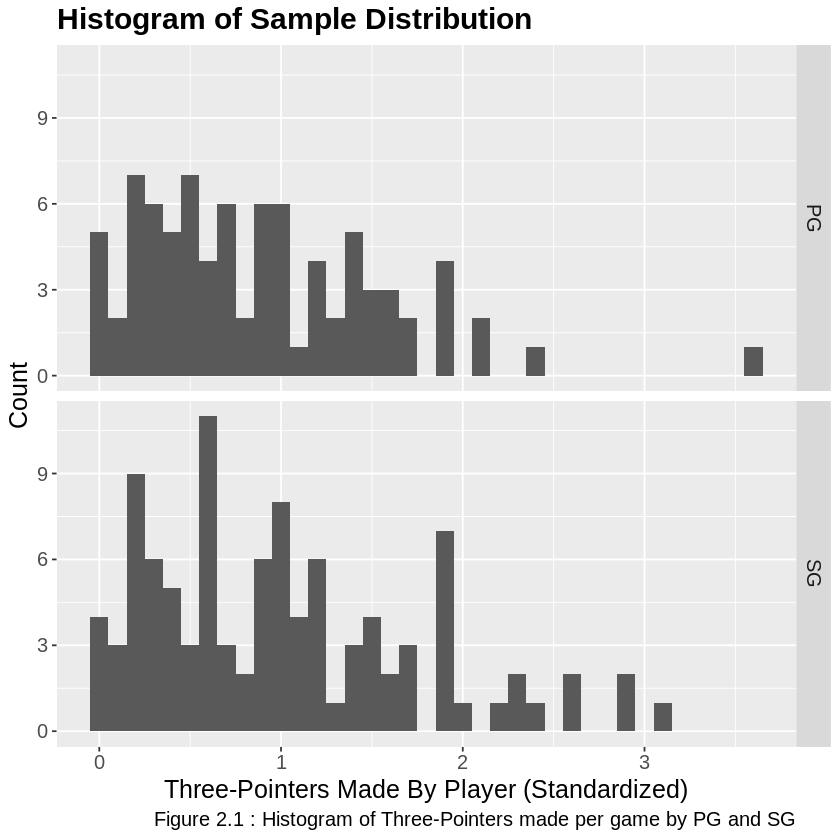

In [41]:
# Plotting the sample distribution using a histogram
options(repr.plot.width = 7, repr.plot.height = 7)

three_point_dist <- tidy_nba |> 
    ggplot(aes(x = three_pts_standardized)) + 
    geom_histogram(binwidth = .1) + 
    xlab("Three-Pointers Made By Player (Standardized)") +
    ylab("Count") +
    labs(caption = "Figure 2.1 : Histogram of Three-Pointers made per game by PG and SG") +
    facet_grid(rows = vars(pos)) + 
    ggtitle("Histogram of Sample Distribution") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

three_point_dist

In Figure 2.1, the sample distributions of `three_pts_standardized` for both guard positions follow a similar pattern - right skewed, as suspected earlier, and have potential outliers. 

We will now analyze the distribution of `three_pts_standardized` for guards using boxplots.

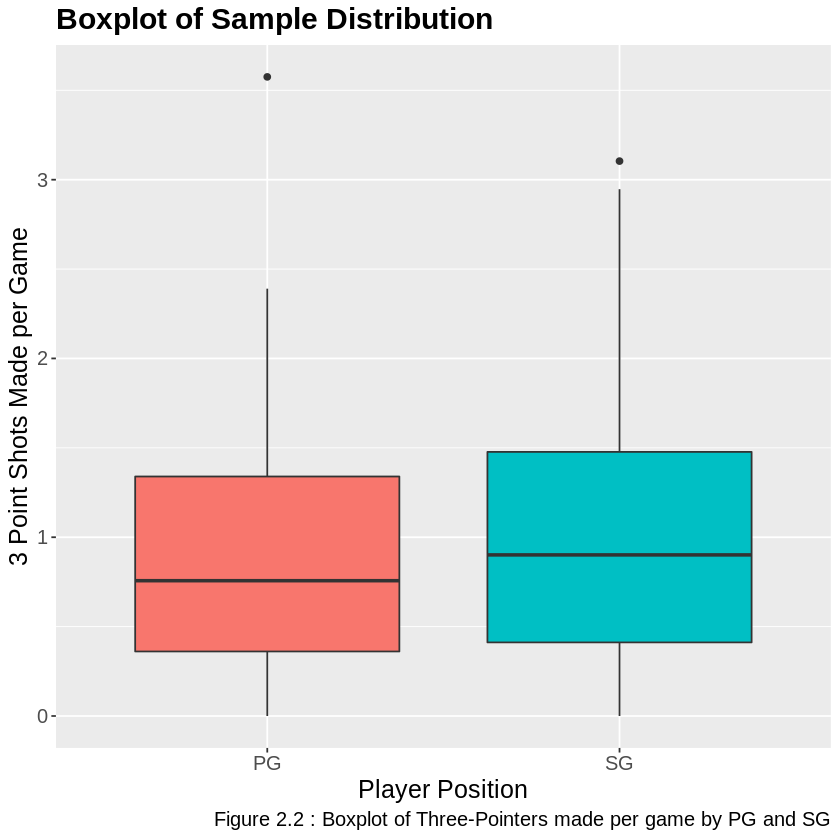

In [42]:
# Plotting the sample distribution using a boxplot
options(repr.plot.width = 7, repr.plot.height = 7)

three_point_boxplot <- tidy_nba |> 
    ggplot(aes(x = pos, y = three_pts_standardized, fill = pos)) +
    geom_boxplot() + 
    ggtitle("Boxplot of Sample Distribution") +
    xlab("Player Position") +
    ylab("3 Point Shots Made per Game") +
    labs(caption = "Figure 2.2 : Boxplot of Three-Pointers made per game by PG and SG") +
    guides(fill = "none") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

three_point_boxplot

In Figure 2.2, both positions have an outlier and follow a similar right-skewed pattern. The interquartile range for `SG` is slightly greater than that of `PG`, indicating that shooting guards who score three-pointers are more spread out.

### Hypothesis Test
Due to sampling variability, simply concluding that Shooting Guards make more three-pointers than Point Guards from this sample is not appropriate and is very unconvincing. Thus, we will perform a hypothesis test at the 5% significance level to determine whether the observed difference in `three_pts_standardized` between point guards and shooting guards is statistically significant.

As shown in Figure 2.1, our sample data is not normally distributed, so we must verify the following assumptions for the Central Limit Theorem to apply:

1. Random sample — this holds true because the data from this season is a random cluster sample, and is likely to be representative of the population.

2. Independent observations — clearly, the sample size of 184 is less than 10% of the population (all NBA guards currently and within the next 10 years).

3. Sufficiently large sample — the sample size for point guards and shooting guards is 84 and 100 respectively (Table 2.1). Since both the samples sizes are greater than 30, they are sufficiently large enough.

Since all the assumptions of the Central Limit Theorem hold, we can assume that the distribution of sample means follows a Normal distribution. Thus, mean is an appropriate choice in summary statistic. Since we are working with quantitative variables between two independent groups, we will use a difference in means $\mu_1 - \mu_2$ as our population parameter where $\mu_1$ and $\mu_2$ are the mean `three_pts_standardized` for point guards and shooting guards respectively.

We will be testing the following null hypothesis $H_0$ and alternative hypothesis $H_A$:
- **Null Hypothesis:** There is no difference in the mean `three_pts_standardized` between point guards and shooting guards.<br>
    $H_0:\mu_1 - \mu_2 = 0$
- **Alternative Hypothesis:** The mean `three_pts_standardized` of shooting guards is greater than that of point guards. <br>
    $H_A:\mu_1 - \mu_2 < 0$

As these are two independent samples, we will perform a **two-sample t-test**. Let $n_1$ be the sample size of point guards with mean `three_pts_standardized` $x$ and let $n_2$ be the sample size of shooting guards with mean `three_pts_standardized` $y$. 

In [43]:
# Mean standardized three-pointers of point guards
x <- nba_summary |>
    filter(pos == "PG") |>
    pull(mean_three_pts)

# Sample size of point guards
n_1 <- nba_summary |>
    filter(pos == "PG") |>
    pull(n)

# Mean standardized three-pointers of shooting guards
y <- nba_summary |>
    filter(pos == "SG") |>
    pull(mean_three_pts)

# Sample size of shooting guards
n_2 <- nba_summary |>
    filter(pos == "SG") |>
    pull(n)

We compute the following test statistic:
$$
T = \frac{x-y}{\sqrt{\frac{s_x^2}{n_1}+\frac{s_y^2}{n_2}}}
$$
where $s_x^2$ and $s_y^2$ are the sample variances for point guards and shooting guards respectively.

In [44]:
# Variance of standardized three-pointers of point guards
s_x <- tidy_nba |>
    filter(pos == "PG") |>
    summarize(var_three_pts = var(three_pts_standardized)) |>
    pull(var_three_pts)

# Variance of standardized three-pointers of shooting guards
s_y <- tidy_nba |>
    filter(pos == "SG") |>
    summarize(var_three_pts = var(three_pts_standardized)) |>
    pull(var_three_pts)

# Calculating the test statistic
test_stat = (x - y) / sqrt((s_x / n_1) + (s_y / n_2))

Assuming our null hypothesis is true, we will construct a null model, which is a **$t$-distribution**, to understand how our test statistic varies due to sampling variation under the null hypothesis. Thus, the test statistic $T$ follows a $t$-distribution with degrees of freedom:

$$
df = n_1 + n_2 - 2
$$

In [45]:
# Calculating degrees of freedom
df <- n_1 + n_2 - 2
tibble(df)

df
<dbl>
182


Table 3.1: Degrees of Freedom

Using the degrees of freedom calculated above, we will determine the probability of obtaining a difference in means as extreme or more extreme than the observed difference in means under the null model which is the **$p$-value**.

In [46]:
# Calculating the p-value
p_value <- pt(abs(test_stat), df, lower.tail = FALSE)
tibble(p_value)

p_value
<dbl>
0.1154399


Table 3.2: $p$-value

The p-value $\approx$ 0.1154 is significantly greater than the significance level 0.05. We will build our $t$-distribution and visualize it using the `infer` workflow.

Warning message:
“Check to make sure the conditions have been met for the theoretical method. {infer} currently does not check these for you.”


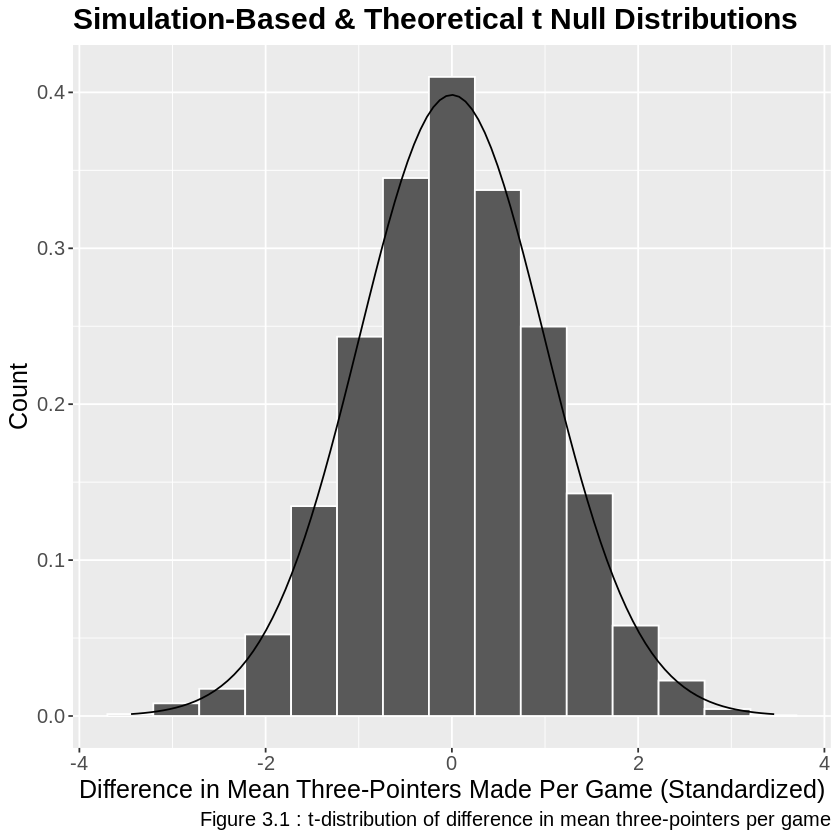

In [47]:
# Generating the t-distribution
t_dist <- tidy_nba |>
    specify(formula = three_pts_standardized ~ pos) |>
    hypothesize(null = "independence") |>
    generate(reps = 5000, type = "permute") |>
    calculate(stat = "t", c("PG", "SG"))

# Plotting the null model
null_model <- visualize(t_dist, method = "both") +
    ggtitle("Simulation-Based & Theoretical t Null Distributions") +
    ylab("Count") +
    xlab("Difference in Mean Three-Pointers Made Per Game (Standardized)") +
    labs(caption = "Figure 3.1 : t-distribution of difference in mean three-pointers per game") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

null_model

In Figure 3.1, the null distribution of our two-sample $t$-statistic follows a $t$-distribution with 182 degrees of freedom which can be seen with the overlay of this $t$-distribution on top of our null distribution. 

Next we shade our null distribution with the $p$-value from Table 3.2 to visualize the results.

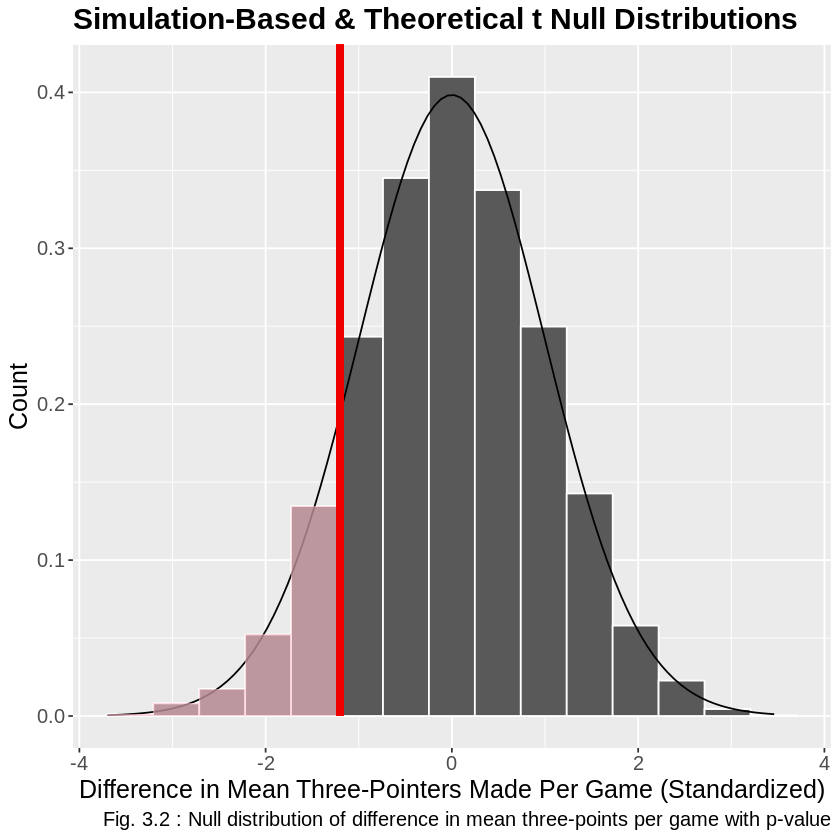

In [48]:
# Observed difference in median of standardized three-pointers
obs_two_sample_t <- tidy_nba |>
    specify(formula = three_pts_standardized ~ pos) |>
    calculate(stat = "t", c("PG", "SG"))

# Visualizing the p-value on the t-distribution
p_value_model <- null_model +
    shade_p_value(obs_stat = obs_two_sample_t, direction = "left") +
    labs(caption = "Fig. 3.2 : Null distribution of difference in mean three-points per game with p-value") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

p_value_model

Figure 3.2, shows we would often observe no difference in means of standardized three-pointers made if the null hypothesis were true.

Since the $p$-value is significantly greater than the significance level, we fail to reject the null hypothesis. Thus, the observed difference in standardized three-pointers made between point guards and shooting guards is statistically insignificant and, thus, there is insufficient evidence to conclude that shooting guards score more three-pointers than point guards.

### Comparison with Confidence Interval

We will construct a 1 - $\alpha$ = 95% confidence interval through bootstrapping and determine whether observed difference in means under the null hypothesis ($\mu_1-\mu_2=0$) falls within that interval. With this, we can verify the results of the hypothesis test we previously performed at the 5% significance level. 

Here we generate and visualize a bootstrap distribution of sample difference in means with 5000 reps using the `infer` workflow.

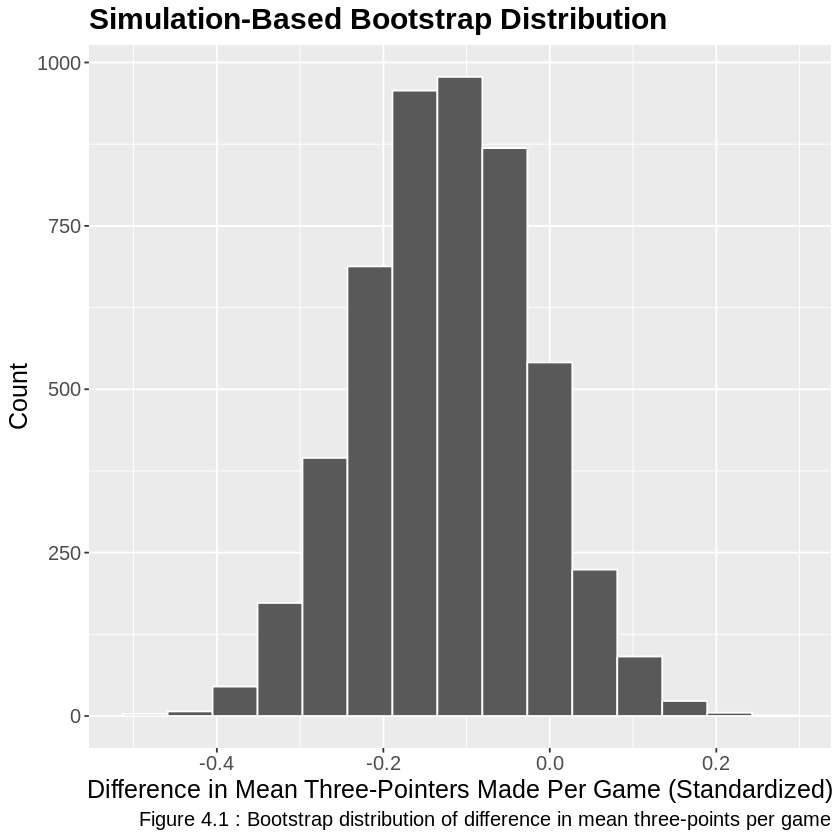

In [49]:
# Generating the bootstrap distribution
diff_in_means_bootstrap <- tidy_nba |> 
    specify(formula = three_pts_standardized ~ pos) |> 
    generate(reps = 5000, type = "bootstrap") |> 
    calculate(stat = "diff in means", order = c("PG", "SG"))

# Plotting bootstrap distribution
bootstrap_dist <- visualize(diff_in_means_bootstrap) +
    ylab("Count") +
    xlab("Difference in Mean Three-Pointers Made Per Game (Standardized)") +
    labs(caption = "Figure 4.1 : Bootstrap distribution of difference in mean three-points per game") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

bootstrap_dist

Here we use the `infer` workflow to construct and shade the 95% confidence interval on the bootstrap distribution using the percentile method.

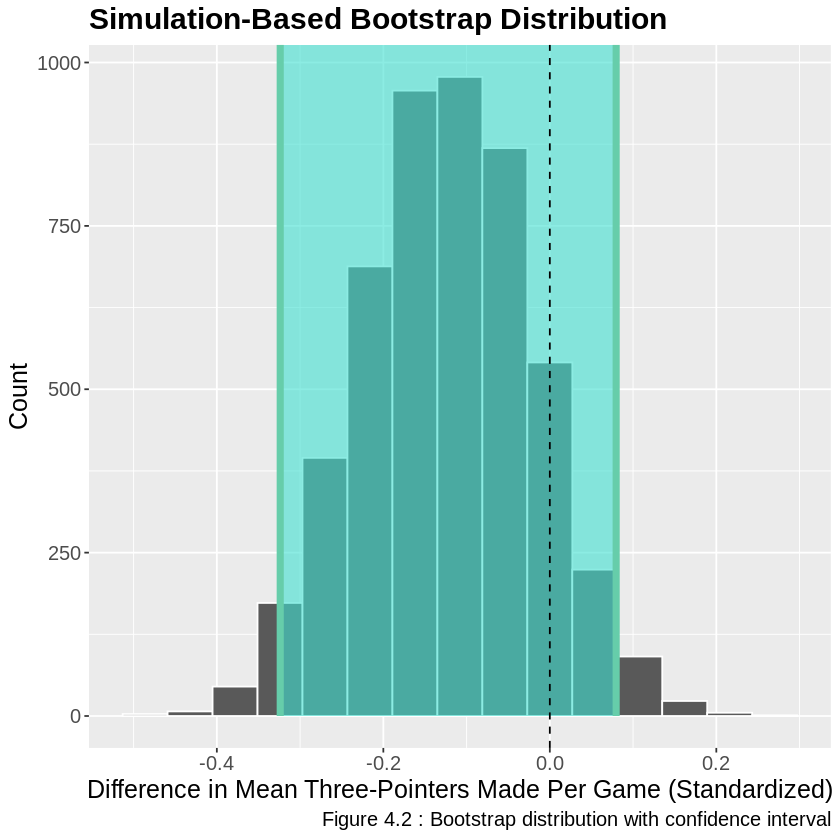

In [52]:
# Getting the 95% percentile confidence interval
diff_in_means_ci <- diff_in_means_bootstrap |> 
    get_ci(level = 0.95, type = "percentile")

# Visualizing the confidence interval and observed test statistic
diff_in_means_ci_plot <- diff_in_means_bootstrap |> 
    visualize() +
    shade_ci(endpoints = diff_in_means_ci) + 
    geom_vline(xintercept = 0, linetype = "dashed") +
    ylab("Count") +
    xlab("Difference in Mean Three-Pointers Made Per Game (Standardized)") +
    labs(caption = "Figure 4.2 : Bootstrap distribution with confidence interval") +
    theme(text = element_text(size = 15),
          plot.title = element_text(face = "bold"))

diff_in_means_ci_plot

In [54]:
diff_in_means_ci

lower_ci,upper_ci
<dbl>,<dbl>
-0.323872,0.07968062


Table 4.1: Confidence Interval

We are 95% confident that the true difference in means of `three_pts_standardized` between point guards and shooting guards falls between -0.32387 and 0.07968 (Table 4.1 and the shaded area of the bootstrap distribution), which is the 95% confidence interval for the population parameter. In Figure 4.2, the null hypothesis (dotted line) lies within this interval so it is plausible that there is no difference in means of `three_pts_standardized`. Thus, we fail to reject the null hypothesis. This conclusion coincides with the result obtained from our two-sample $t$-test.

### Results and Analysis
According to the hypothesis test and confidence interval from the bootstrap distribution, there is unlikely to be any difference in the true mean of standardized three-pointers between point guards and shooting guards. With the two-sample $t$-test, we calculated the probability of obtaining a value just as or more extreme than the observed mean difference whereas with bootstrapping, we could visualize and see if the difference of means of 0 falls within our confidence interval. Even though both approaches aim for the same goal, bootstrapping does not rely on assumptions about the underlying population distributions. On the other hand, a two-sample $t$-test requires either the population to be normally distributed or relies on the Central Limit Theorem which requires further assumptions about the population. Furthermore, bootstrapping is easier to understand due to its simulation-based nature and visualization of the results. 

In the case of the difference in standardized three-pointers made between point guards and shooting guards, both approaches yield the same results and, thus, we can say our conclusion is reasonable. However, we risk committing a Type II error if there truly is a difference in standardized three-pointers made.

## Discussion 

As shown above, both our $p$-value of 11.54% and a difference in means of 0 falling within our 95% confidence interval both suggest that there is no significant difference in the number of 3-point shots made per game by point guards and shooting guards in the 2017-18 NBA season, which suggests that both groups are roughly equally proficient in scoring three-pointers. This result is what we expected to find, with the rise in three-point shots made by point guards, we predicted it would be difficult for shooting guards to outclass them in today's game.  The results of this study could result in coaches re-evaluating the types of players they place in each position. With two high scoring positions, it could now be an option for coaches to sacrifice the defensive capabilities for shooting capabilities in some players to help them win more games. On the other hand, it could also help coaches plan out their defensive tactics to prevent their opponents from scoring many three pointers. 

### Further Implications
Our findings raise a number of future questions:
- Do teams with a higher scoring point guard win more games than teams with a higher scoring shooting guard?
- Does a point guards' ability to score three pointers come from their efficient ball handling, which allows them to create more space?
- How carefully should defenders guard shooting guards compared to point guards?

## References
NBA Player Stats 2017-2018. (2018, November 4). Kaggle. https://www.kaggle.com/datasets/mcamli/nba17-18

Ortega, E., Vélez, D. C., De Baranda, P. S., & Palao, J. M. (2006). Analysis of the final actions used in basketball during formative years according to player’s position. ResearchGate. https://www.researchgate.net/publication/255994752_Analysis_of_the_final_actions_used_in_basketball_during_formative_years_according_to_player's_position

Wang, F., & Zheng, G. (2022). Examining positional difference in basketball players’ field goal accuracy using Bayesian hierarchical model. International Journal of Sports Science & Coaching, 17(4), 848–859. https://doi.org/10.1177/17479541221096772